# Exact simulation with Qiskit primitives

The reference primitives in Qiskit can perform local statevector simulations, which is useful for quickly prototyping algorithms. 

The `Estimator` primitive can compute an expectation value, and the `Sampler` primitive can compute circuit output probabilities. 

## Compute circuit output probabilities with `Sampler` primitive

Follow these instructions to get the probability distribution of a quantum circuit with the [`qiskit.primitives.Sampler`](../api/qiskit/qiskit.primitives.Sampler) primitive.

<Admonition type="note">
  While this guide uses Qiskit’s reference implementation, the `Sampler` primitive can be run with any provider using [`qiskit.primitives.BackendSampler`](../api/qiskit/qiskit.primitives.BackendSampler).

  ```python
  from qiskit.primitives import BackendSampler
  from <some_qiskit_provider> import QiskitProvider

  provider = QiskitProvider()
  backend = provider.get_backend('backend_name')
  sampler = BackendSampler(backend)
  ```

  There are some providers that implement primitives natively (see [the Qiskit Ecosystem page](https://qiskit.github.io/ecosystem#providers) for more details).
</Admonition>

### Initialize QuantumCircuit

The first step is to create the [`qiskit.circuit.QuantumCircuit`](../api/qiskit/qiskit.circuit.QuantumCircuit)s from which you want to obtain the probability distribution.

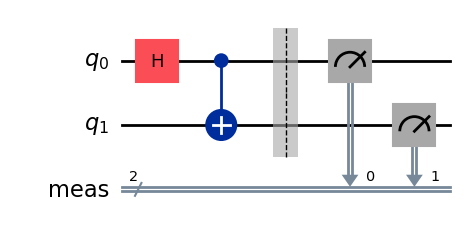

In [2]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
qc.draw("mpl", style="iqp")

![Initial QuantumCircuit](/images/verify/simulate-with-qiskit-primitives/sampler-initialize.png "Initial QuantumCircuit")

<Admonition type="note">
The [`qiskit.circuit.QuantumCircuit`](../api/qiskit/qiskit.circuit.QuantumCircuit) you pass to [`qiskit.primitives.Sampler`](../api/qiskit/qiskit.primitives.Sampler) must include measurements.
</Admonition>

### Initialize `Sampler`

Next, create a [`qiskit.primitives.Sampler`](../api/qiskit/qiskit.primitives.Sampler) instance.

In [3]:
from qiskit.primitives import Sampler

sampler = Sampler()

### Run and get results

Now that you have defined your `sampler`, run it by calling the [`qiskit.primitives.Sampler.run`](../api/qiskit/qiskit.primitives.Sampler#run) method, which returns an instance of [`qiskit.providers.JobV1`](../api/qiskit/qiskit.providers.JobV1). You can get the results from the job (as a [`qiskit.primitives.SamplerResult`](../api/qiskit/qiskit.primitives.SamplerResult) object) with the [`qiskit.providers.JobV1.result`](../api/qiskit/qiskit.providers.JobV1#result) method.

In [4]:
job = sampler.run(qc)
result = job.result()
print(result)

SamplerResult(quasi_dists=[{0: 0.5, 3: 0.5}], metadata=[{}])


While this example only uses one [`qiskit.circuit.QuantumCircuit`](../api/qiskit/qiskit.circuit.QuantumCircuit), you can sample multiple circuits by passing a `list` of [`qiskit.circuit.QuantumCircuit`](../api/qiskit/qiskit.circuit.QuantumCircuit) instances to the [`qiskit.primitives.Sampler.run`](../api/qiskit/qiskit.primitives.Sampler#run) method.

### Get the probability distribution

From these results you can extract the quasi-probability distributions with the attribute [`qiskit.primitives.SamplerResult.quasi_dists`](../api/qiskit/qiskit.primitives.SamplerResult#quasi_dists).

Even though there is only one circuit in this example, [`qiskit.primitives.SamplerResult.quasi_dists`](../api/qiskit/qiskit.primitives.SamplerResult#quasi_dists) returns a list of [`qiskit.result.QuasiDistribution`](../api/qiskit/qiskit.result.QuasiDistribution)s.
`result.quasi_dists[i]` is the quasi-probability distribution of the `i`<sup>th</sup> circuit.

<Admonition type="note">
A quasi-probability distribution differs from a probability distribution in that negative values are also allowed.
However, the quasi-probabilities must sum up to 1 like probabilities.
Negative quasi-probabilities may appear when using error mitigation techniques.
</Admonition>

In [5]:
quasi_dist = result.quasi_dists[0]
print(quasi_dist)

{0: 0.5, 3: 0.5}


#### Probability distribution with binary outputs

If you prefer to see the output keys as binary strings instead of decimal numbers, you can use the [`qiskit.result.QuasiDistribution.binary_probabilities`](../api/qiskit/qiskit.result.QuasiDistribution#binary_probabilities) method.

In [6]:
print(quasi_dist.binary_probabilities())

{'00': 0.4999999999999999, '11': 0.4999999999999999}


### Parameterized circuit with `Sampler`

The [`qiskit.primitives.Sampler`](../api/qiskit/qiskit.primitives.Sampler) primitive can be run with unbound parameterized circuits like the one below.
You can also manually bind values to the parameters of the circuit and follow the steps of the previous example.

In [7]:
from qiskit.circuit import Parameter

theta = Parameter('θ')
param_qc = QuantumCircuit(2)
param_qc.ry(theta, 0)
param_qc.cx(0,1)
param_qc.measure_all()
print(param_qc.draw(style="iqp"))

        ┌───────┐      ░ ┌─┐   
   q_0: ┤ Ry(θ) ├──■───░─┤M├───
        └───────┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────────┤ X ├─░──╫─┤M├
                 └───┘ ░  ║ └╥┘
meas: 2/══════════════════╩══╩═
                          0  1 



The main difference from the previous case is that now you need to specify the sets of parameter values for which you want to evaluate the expectation value as a `list` of `list`s of `float`s. The `i`<sup>th</sup> element of the outer `list` is the set of parameter values that corresponds to the `i`<sup>th</sup> circuit.

In [8]:
import numpy as np

parameter_values = [[0], [np.pi/6], [np.pi/2]]

job = sampler.run([param_qc]*3, parameter_values=parameter_values)
dists = job.result().quasi_dists

for i in range(3):
    print(f"Parameter: {parameter_values[i][0]:.5f}\t Probabilities: {dists[i]}")

Parameter: 0.00000	 Probabilities: {0: 1.0}
Parameter: 0.52360	 Probabilities: {0: 0.933012701892219, 3: 0.066987298107781}
Parameter: 1.57080	 Probabilities: {0: 0.5, 3: 0.5}



### Change run options

Your workflow might require tuning primitive run options, such as the number of shots.

By default, the reference [`qiskit.primitives.Sampler`](../api/qiskit/qiskit.primitives.Sampler) class performs an exact statevector
calculation based on the [`qiskit.quantum_info.Statevector`](../api/qiskit/qiskit.quantum_info.Statevector) class. However, this can be
modified to include shot noise if the number of `shots` is set.
For reproducibility purposes, a `seed` will also be set in the following examples.

There are two main ways of setting options in the [`qiskit.primitives.Sampler`](../api/qiskit/qiskit.primitives.Sampler):

- Set keyword arguments in the [`qiskit.primitives.Sampler.run`](../api/qiskit/qiskit.primitives.Sampler#run) method.
- Modify [`qiskit.primitives.Sampler`](../api/qiskit/qiskit.primitives.Sampler) options.

#### Set keyword arguments for [`qiskit.primitives.Sampler.run`](../api/qiskit/qiskit.primitives.Sampler#run)

If you only want to change the settings for a specific run, it can be more convenient to set the options inside the [`qiskit.primitives.Sampler.run`](../api/qiskit/qiskit.primitives.Sampler#run) method. You can do this by passing them as keyword arguments.

In [9]:
job = sampler.run(qc, shots=2048, seed=123)
result = job.result()
print(result)

SamplerResult(quasi_dists=[{0: 0.5205078125, 3: 0.4794921875}], metadata=[{'shots': 2048}])


#### Modify [`qiskit.primitives.Sampler`](../api/qiskit/qiskit.primitives.Sampler) options

If you want to keep some configuration values for several runs, it can be better to change the [`qiskit.primitives.Sampler`](../api/qiskit/qiskit.primitives.Sampler) options. That way you can use the same [`qiskit.primitives.Sampler`](../api/qiskit/qiskit.primitives.Sampler) object as many times as you wish without having to rewrite the configuration values every time you use [`qiskit.primitives.Sampler.run`](../api/qiskit/qiskit.primitives.Sampler#run).

#### Modify existing [`qiskit.primitives.Sampler`](../api/qiskit/qiskit.primitives.Sampler)

If you prefer to change the options of an already-defined [`qiskit.primitives.Sampler`](../api/qiskit/qiskit.primitives.Sampler), you can use [`qiskit.primitives.Sampler.set_options`](../api/qiskit/qiskit.primitives.Sampler#set_options) and introduce the new options as keyword arguments.

In [10]:
sampler.set_options(shots=2048, seed=123)

job = sampler.run(qc)
result = job.result()
print(result)

SamplerResult(quasi_dists=[{0: 0.5205078125, 3: 0.4794921875}], metadata=[{'shots': 2048}])


#### Define a new [`qiskit.primitives.Sampler`](../api/qiskit/qiskit.primitives.Sampler) with the options

If you prefer to define a new [`qiskit.primitives.Sampler`](../api/qiskit/qiskit.primitives.Sampler) with new options, define a `dict` like this one:

In [11]:
options = {"shots": 2048, "seed": 123}

You can then introduce it into your new [`qiskit.primitives.Sampler`](../api/qiskit/qiskit.primitives.Sampler) with the `options` argument.

In [12]:
sampler = Sampler(options=options)

job = sampler.run(qc)
result = job.result()
print(result)

SamplerResult(quasi_dists=[{0: 0.5205078125, 3: 0.4794921875}], metadata=[{'shots': 2048}])


## Compute an expectation value with the `Estimator` primitive

Follow these instructions to get the expected value of an observable for a given quantum circuit with the [`qiskit.primitives.Estimator`](../api/qiskit/qiskit.primitives.Estimator) primitive.

<Admonition type="note">
  While this guide uses Qiskit’s reference implementation, the `Estimator` primitive can be run with any provider using [`qiskit.primitives.BackendEstimator`](../api/qiskit/qiskit.primitives.BackendEstimator).

  ```python
  from qiskit.primitives import BackendEstimator
  from <some_qiskit_provider> import QiskitProvider

  provider = QiskitProvider()
  backend = provider.get_backend('backend_name')
  estimator = BackendEstimator(backend)
  ```

  There are some providers that implement primitives natively (see [the Qiskit Ecosystem page](https://qiskit.github.io/ecosystem/#primitives) for more details).
</Admonition>

### Initialize observables

The first step is to define the observables whose expected value you want to compute. Each observable can be any `BaseOperator`, like the operators from [`qiskit.quantum_info`](../api/qiskit/quantum_info).
Among them it is preferable to use [`qiskit.quantum_info.SparsePauliOp`](../api/qiskit/qiskit.quantum_info.SparsePauliOp).

In [13]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["II", "XX", "YY", "ZZ"], coeffs=[1, 1, -1, 1])

### Initialize QuantumCircuit

Next, create the [`qiskit.circuit.QuantumCircuit`](../api/qiskit/qiskit.circuit.QuantumCircuit) for which you want to obtain the expected value.

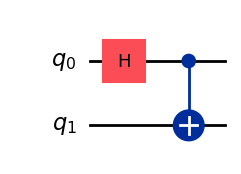

In [14]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.draw("mpl", style="iqp")

![Initial QuantumCircuit](/images/verify/simulate-with-qiskit-primitives/estimator-initialize.png "Initial QuantumCircuit")

<Admonition type="note">
  The [`qiskit.circuit.QuantumCircuit`](../api/qiskit/qiskit.circuit.QuantumCircuit) you pass to [`qiskit.primitives.Estimator`](../api/qiskit/qiskit.primitives.Estimator) must not include any measurements.
</Admonition>

### Initialize `Estimator`

Next, instantiate an [`qiskit.primitives.Estimator`](../api/qiskit/qiskit.primitives.Estimator).

In [15]:
from qiskit.primitives import Estimator

estimator = Estimator()

### Run and get results

Now that you have defined your `estimator`, you can run your estimation by calling the [`qiskit.primitives.Estimator.run`](../api/qiskit/qiskit.primitives.Estimator#run) method,
which returns an instance of [`qiskit.providers.JobV1`](../api/qiskit/qiskit.providers.JobV1). You can get the results from the job (as a [`qiskit.primitives.EstimatorResult`](../api/qiskit/qiskit.primitives.EstimatorResult) object)
with the [`qiskit.providers.JobV1.result`](../api/qiskit/qiskit.providers.JobV1#result) method.

In [18]:
job = estimator.run(qc, observable)
result = job.result()
print(result)

EstimatorResult(values=array([4.]), metadata=[{}])


This example only uses one [`qiskit.circuit.QuantumCircuit`](../api/qiskit/qiskit.circuit.QuantumCircuit) and one observable. If you want to get expectation values for multiple circuits and observables, you can pass a `list` of [`qiskit.circuit.QuantumCircuit`](../api/qiskit/qiskit.circuit.QuantumCircuit)s and a list of `BaseOperator`s to the [`qiskit.primitives.Estimator.run`](../api/qiskit/qiskit.primitives.Estimator#run) method. Both `list`s must have the same length.

#### Get the expected value

From these results you can extract the expected values with the attribute [`qiskit.primitives.EstimatorResult.values`](../api/qiskit/qiskit.primitives.EstimatorResult#values).

[`qiskit.primitives.EstimatorResult.values`](../api/qiskit/qiskit.primitives.EstimatorResult#values) returns a `numpy.ndarray`
whose `i`<sup>th</sup> element is the expectation value corresponding to the `i`<sup>th</sup> circuit and `i`<sup>th</sup> observable.

In [19]:
exp_value = result.values[0]
print(exp_value)

3.999999999999999


### Parameterized circuit with `Estimator`

The [`qiskit.primitives.Estimator`](../api/qiskit/qiskit.primitives.Estimator) primitive can be run with unbound parameterized circuits like the one below.
You can also manually bind values to the parameters of the circuit and follow the steps of the previous example.

In [20]:
from qiskit.circuit import Parameter

theta = Parameter('θ')
param_qc = QuantumCircuit(2)
param_qc.ry(theta, 0)
param_qc.cx(0,1)
print(param_qc.draw(style="iqp"))

     ┌───────┐     
q_0: ┤ Ry(θ) ├──■──
     └───────┘┌─┴─┐
q_1: ─────────┤ X ├
              └───┘




The main difference with the previous case is that now you need to specify the sets of parameter values for which you want to evaluate the expectation value as a `list` of `list`s of `float`s.
The `i`<sup>th</sup> element of the outer `list` is the set of parameter values that corresponds to the `i`<sup>th</sup> circuit and observable.

In [21]:
import numpy as np

parameter_values = [[0], [np.pi/6], [np.pi/2]]

job = estimator.run([param_qc]*3, [observable]*3, parameter_values=parameter_values)
values = job.result().values

for i in range(3):
    print(f"Parameter: {parameter_values[i][0]:.5f}\t Expectation value: {values[i]}")

Parameter: 0.00000	 Expectation value: 2.0
Parameter: 0.52360	 Expectation value: 3.0
Parameter: 1.57080	 Expectation value: 4.0




### Change run options

Your workflow might require tuning primitive run options, such as the number of shots.

By default, the reference [`qiskit.primitives.Estimator`](../api/qiskit/qiskit.primitives.Estimator) class performs an exact statevector calculation based on the [`qiskit.quantum_info.Statevector`](../api/qiskit/qiskit.quantum_info.Statevector) class. However, this can be modified to include shot noise if the number of `shots` is set. For reproducibility purposes, a `seed` will also be set in the following examples.

There are two main ways of setting options in the [`qiskit.primitives.Estimator`](../api/qiskit/qiskit.primitives.Estimator):

- Set keyword arguments in the [`qiskit.primitives.Estimator.run`](../api/qiskit/qiskit.primitives.Estimator#run) method.
- Modify [`qiskit.primitives.Estimator`](../api/qiskit/qiskit.primitives.Estimator) options.

#### Set keyword arguments for [`qiskit.primitives.Estimator.run`](../api/qiskit/qiskit.primitives.Estimator#run)

If you only want to change the settings for a specific run, it can be more convenient to set the options inside the [`qiskit.primitives.Estimator.run`](../api/qiskit/qiskit.primitives.Estimator#run) method. You can do this by passing them as keyword arguments.

In [22]:
job = estimator.run(qc, observable, shots=2048, seed=123)
result = job.result()
print(result)

EstimatorResult(values=array([4.]), metadata=[{'variance': 3.552713678800501e-15, 'shots': 2048}])


In [23]:
print(result.values[0])

3.999999998697238


#### Modify [`qiskit.primitives.Estimator`](../api/qiskit/qiskit.primitives.Estimator) options

If you want to keep some configuration values for several runs, it can be better to change the [`qiskit.primitives.Estimator`](../api/qiskit/qiskit.primitives.Estimator) options. That way you can use the same [`qiskit.primitives.Estimator`](../api/qiskit/qiskit.primitives.Estimator) object as many times as you wish without having to
rewrite the configuration values every time you use [`qiskit.primitives.Estimator.run`](../api/qiskit/qiskit.primitives.Estimator#run).

#### Modify existing [`qiskit.primitives.Estimator`](../api/qiskit/qiskit.primitives.Estimator)

If you prefer to change the options of an already-defined [`qiskit.primitives.Estimator`](../api/qiskit/qiskit.primitives.Estimator), you can use the method [`qiskit.primitives.Estimator.set_options`](../api/qiskit/qiskit.primitives.Estimator#set_options) and introduce the new options as keyword arguments.

In [24]:
estimator.set_options(shots=2048, seed=123)

job = estimator.run(qc, observable)
result = job.result()
print(result)

EstimatorResult(values=array([4.]), metadata=[{'variance': 3.552713678800501e-15, 'shots': 2048}])


In [25]:
print(result.values[0])

3.999999998697238


#### Define a new [`qiskit.primitives.Estimator`](../api/qiskit/qiskit.primitives.Estimator) with the options

If you prefer to define a new [`qiskit.primitives.Estimator`](../api/qiskit/qiskit.primitives.Estimator) with new options, define a `dict` like this one:

In [26]:
options = {"shots": 2048, "seed": 123}

You can then introduce it into your new [`qiskit.primitives.Estimator`](../api/qiskit/qiskit.primitives.Estimator) with the `options` argument.

In [27]:
estimator = Estimator(options=options)

job = estimator.run(qc, observable)
result = job.result()
print(result)

EstimatorResult(values=array([4.]), metadata=[{'variance': 3.552713678800501e-15, 'shots': 2048}])


In [28]:
print(result.values[0])

3.999999998697238


## Next steps

<Admonition type="tip" title="Recommendations">
  - For higher-performance simulation that can handle larger circuits, or to incorporate noise models into your simulation, see [Exact and noisy simulation with Qiskit Aer primitives](simulate-with-qiskit-aer).
  - To learn how to use Quantum Composer for simulation, try the [Explore gates and circuits with the Quantum Composer](https://learning.quantum.ibm.com/tutorial/explore-gates-and-circuits-with-the-quantum-composer) tutorial.
  - Read the [Qiskit Estimator API](/api/qiskit/qiskit.primitives.Estimator) reference.
  - Read the [Qiskit Sampler API](/api/qiskit/qiskit.primitives.Sampler) reference.
  - Learn how to run on a physical system in the [Run](../run) section.
</Admonition>